This script will compile shape/texture measure for later voxelwise analyses.

In [37]:
import os
import pandas as pd
import numpy as np
import readline
import rpy2
import rpy2.robjects as robjects
r = robjects.r

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

from rpy2.robjects import pandas2ri
pandas2ri.activate()

from sklearn.preprocessing import scale

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm
from menpo.shape import PointCloud

## Load

Load the preprocessing steps

In [53]:
idir  = "/data1/famface01/analysis/encoding/12_Features/identity_shape_analysis"
ifile = '%s/a01_preproc_shape_stim.npz' % idir
data  = np.load(ifile)

Load the texture PCA comps

In [40]:
idir = "/data1/famface01/analysis/encoding/12_Features/identity_pca"
texture_scores = pd.read_csv(os.path.join(idir, "texture_pca_scores.csv"))
texture_sym_scores = pd.read_csv(os.path.join(idir, "texture_sym_pca_scores.csv"))

t_eigs = np.loadtxt(os.path.join(idir, "texture_pca_eigs.txt"))
ts_eigs = np.loadtxt(os.path.join(idir, "texture_sym_pca_eigs.txt"))

Load the shape PCA comps

In [41]:
idir = "/data1/famface01/analysis/encoding/12_Features/identity_pca"
shape_scores = pd.read_csv(os.path.join(idir, "shape_pca_scores.csv"))
shape_sym_scores = pd.read_csv(os.path.join(idir, "shape_sym_pca_scores.csv"))

s_eigs = np.loadtxt(os.path.join(idir, "shape_pca_eigs.txt"))
ss_eigs = np.loadtxt(os.path.join(idir, "shape_sym_pca_eigs.txt"))

Remove the video names in the first column.

In [42]:
vnames = data['vidnames']
print(np.alltrue(vnames == texture_sym_scores.ix[:,0]))
print(np.alltrue(vnames == shape_scores.ix[:,0]))
print(np.alltrue(vnames == shape_sym_scores.ix[:,0]))

True
True
True


In [43]:
texture_scores = texture_scores.ix[:,1:]
texture_sym_scores = texture_sym_scores.ix[:,1:]

shape_scores = shape_scores.ix[:,1:]
shape_sym_scores = shape_sym_scores.ix[:,1:]

In [44]:
pd.DataFrame(data['unfam_df']).head()

,0,1,2,3,4
0,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,3,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
1,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,9,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
2,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,15,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
3,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,21,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
4,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,27,unfam,/data1/famface01/data/stimuli/vids/eight_frame...


In [46]:
t_eigs[:,1].round(2)[:10]

array([ 0.43,  0.66,  0.72,  0.76,  0.79,  0.82,  0.83,  0.84,  0.85,  0.86])

In [47]:
sorted(data.keys())

['mirror_ref_shape',
 'ref_shape',
 'step01_scale',
 'step02_pose_mse',
 'step02_pose_scores',
 'step03_eye_blink',
 'step04_mouth',
 'step05_frame_shapes',
 'step06_diff_shapes',
 'step06_mean_shapes',
 'step07_diff_sym_shapes',
 'step07_mean_sym_shapes',
 'unfam_df',
 'vidnames']

In [48]:
subj = "sub02"
infile = "/data1/famface01/analysis/encoding/ShapeAnalysis/data/roi_n_more_%s.rda" % subj
r.load(infile)

# Variables
onsets     = np.array(r.dat.rx2('basics').rx2('timing').rx2('onset'))
questions  = np.array(r['as.character'](r.dat.rx2('basics').rx2('timing').rx2('question')))
runs       = np.array(r.dat.rx2('basics').rx2('timing').rx2('run'))
uruns      = np.unique(runs)
timing     = pandas2ri.ri2py(r.dat.rx2('basics').rx2('timing'))

In [49]:
print(r.names(r.dat.rx2('basics')))
#print(r.dat.rx2('basics').rx2('frame.timing'))
pandas2ri.ri2py_dataframe(r.dat.rx2('basics').rx2('frame.timing')).head()

[1] "frame.df"     "frame.timing" "timing"      



,frame.ind,func.ind,run,onset,local.onset,duration,frame,video
4913,2457,1,1,0.001467,0.001467,0.25,3,Hank_Aaron_U067_vid03_clip04_2secs
4915,2458,1,1,0.251467,0.251467,0.25,9,Hank_Aaron_U067_vid03_clip04_2secs
4917,2459,1,1,0.501467,0.501467,0.25,15,Hank_Aaron_U067_vid03_clip04_2secs
4919,2460,1,1,0.751467,0.751467,0.25,21,Hank_Aaron_U067_vid03_clip04_2secs
4921,2461,1,1,1.001467,1.001467,0.25,27,Hank_Aaron_U067_vid03_clip04_2secs


## Measures

1. Scale
2. Pose Scores (4)
3. Mouth Scores (2)


In [54]:
sorted(data.keys())

['mirror_ref_shape',
 'ref_shape',
 'step01_frame_shapes',
 'step01_scale',
 'step02_frame_shapes',
 'step02_pose_mse',
 'step02_pose_scores',
 'step03_eye_blink',
 'step04_mouth',
 'step05_frame_shapes',
 'step06_diff_shapes',
 'step06_mean_shapes',
 'step07_diff_sym_shapes',
 'step07_mean_sym_shapes',
 'unfam_df',
 'vidnames']

In [176]:
def eucdist(mat1, mat2):
    return np.mean(np.sqrt(np.sum((mat1 - mat2)**2, axis=1)))

def shape_framewise_diff(frame_dat):
    """Gets the framewise displacement for each frame to the next within a given video"""
    n = frame_dat.shape[2]
    fds = []
    for i in range(n-1):
        fd = eucdist(frame_dat[:,:,i], frame_dat[:,:,i+1])
        fds.append(fd)
    fds = np.array(fds)
    return fds

### Absolute Mean Measures

We average the values across the time (2s) for each video.

In [76]:
# We loop through the starting indices to average
start_inds0 = np.array(r.seq(0,data['step01_scale'].shape[0]-1,8))
start_inds1 = np.array(r.seq(1,data['step05_frame_shapes'].shape[2]-1,8))

#### 1: Scale

In [83]:
print data['step01_scale'].shape

r01_scale = []
for si in tqdm(start_inds0):
    ret = data['step01_scale'][si:(si+8)].mean()
    r01_scale.append(ret)
r01_scale = np.array(r01_scale)

  9%|▉         | 79/864 [00:00<00:01, 784.68it/s]

(6912,)


100%|██████████| 864/864 [00:00<00:00, 1332.79it/s]


In [78]:
r01_scale[:10]

array([ 1.06733281,  1.62719121,  1.47620884,  0.96738301,  1.16950446,
        0.97519623,  1.00904329,  1.21312513,  1.40379761,  1.53728191])

#### 2: Pose

In [84]:
print data['step02_pose_scores'].shape

r02_pose_scores = []
for si in tqdm(start_inds1):
    ret = data['step02_pose_scores'][si:(si+8)].mean(axis=0)
    r02_pose_scores.append(ret)
r02_pose_scores = np.array(r02_pose_scores)

  4%|▍         | 34/864 [00:00<00:02, 333.20it/s]

(6913, 4)


100%|██████████| 864/864 [00:01<00:00, 632.34it/s]


In [87]:
print data['step02_pose_mse'].shape

r02_pose_mse = []
for si in tqdm(start_inds0):
    ret = data['step02_pose_mse'][si:(si+8)].mean(axis=0)
    r02_pose_mse.append(ret)
r02_pose_mse = np.array(r02_pose_mse)

  9%|▉         | 80/864 [00:00<00:00, 799.84it/s]

(6912,)


100%|██████████| 864/864 [00:00<00:00, 1358.36it/s]


In [86]:
print r02_pose_scores[:10]
print r02_pose_mse[:10]

[[ -8.42720388  -6.19560762   0.68772958   2.06813895]
 [-21.7606128    1.03601492   9.73275981   6.35362464]
 [-28.64019732 -11.52983994   8.93943451   8.68348722]
 [  6.15050415  -0.9389162   -1.36363926   0.6573992 ]
 [ 16.92368515  -7.52300944  -9.91625609  -0.94378705]
 [  5.74490258  -8.16558051 -14.88125815  -2.59604937]
 [ 17.90257589  23.09640839   1.75668514  -2.87079993]
 [ -9.20061788   9.48205803  -1.85683018   6.52272864]
 [ -6.34429651   4.06956126   3.84822612   4.61830454]
 [ 50.32581611  -5.75037103   3.64468669  -3.0515002 ]]
[ 1.95059986  7.99294113  6.94414171  4.76169268  9.24024728  8.13471252
  2.2132205   3.40540888  2.33876336  4.58919439]


#### 3: Mouth

In [88]:
print data['step04_mouth'].shape

r03_mouth_scores = []
for si in tqdm(start_inds1):
    ret = data['step04_mouth'][si:(si+8)].mean(axis=0)
    r03_mouth_scores.append(ret)
r03_mouth_scores = np.array(r03_mouth_scores)

  7%|▋         | 57/864 [00:00<00:01, 567.42it/s]

(6912, 2)


100%|██████████| 864/864 [00:00<00:00, 966.56it/s]


#### 4: Left Over

We take the difference of each frame from the mean frame. This reflects anything that we haven't captured with our pose or mouth removal business.

In [91]:
print data['step05_frame_shapes'].shape
print data['step06_mean_shapes'].shape

r04_mean_fds = []
for i,si in tqdm(enumerate(start_inds1), total=len(start_inds1)):
    frame_shapes = data['step05_frame_shapes'][:,:,si:(si+8)]
    fds = []
    for j in range(8):
        ret = eucdist(data['step06_mean_shapes'][i], frame_shapes[:,:,j])
        fds.append(ret)
    r04_mean_fds.append(np.array(fds).mean())
r04_mean_fds = np.array(r04_mean_fds)

  0%|          | 1/864 [00:00<01:34,  9.17it/s]

(68, 2, 6913)
(864, 68, 2)


100%|██████████| 864/864 [01:11<00:00, 12.14it/s]


In [92]:
r04_mean_fds[:10]

array([ 0.79081297,  0.8345708 ,  1.67425297,  1.10693008,  1.50433418,
        2.40202122,  0.92493662,  0.66811677,  1.01575574,  0.99981011])

#### 5: Face Asymmetry 

Compare the non-mirror to the mirror face.

In [97]:
print data['step06_mean_shapes'].shape

r05_asym = []
for i in tqdm(range(data['step06_mean_shapes'].shape[0])):
    asym = eucdist(data['step06_mean_shapes'][i], data['step07_mean_sym_shapes'][i])
    r05_asym.append(asym)
r05_asym = np.array(r05_asym)

  1%|          | 6/864 [00:00<00:15, 55.45it/s]

(864, 68, 2)


100%|██████████| 864/864 [00:08<00:00, 101.11it/s]


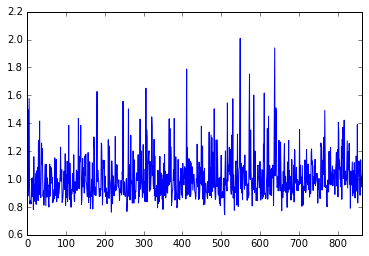

In [96]:
pd.Series(r05_asym).plot()

#### 6: Mean Sym Face

Compare to reference.

In [98]:
r06_mean_face = []
for i in tqdm(range(data['step06_mean_shapes'].shape[0])):
    d = eucdist(data['step07_mean_sym_shapes'][i], data['mirror_ref_shape'])
    r06_mean_face.append(d)
r06_mean_face = np.array(r06_mean_face)

100%|██████████| 864/864 [00:04<00:00, 206.18it/s]


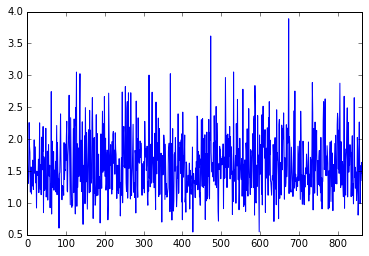

In [99]:
pd.Series(r06_mean_face).plot()

#### 7: PCA Comps

In [116]:
from sklearn.metrics.pairwise import euclidean_distances
r07_pca_texture = euclidean_distances(texture_sym_scores.ix[:,:200], np.zeros((1,200)))[:,0]
r07_pca_shape = euclidean_distances(shape_sym_scores.ix[:,:50], np.zeros((1,50)))[:,0]

In [120]:
# Note that since pca shape is very related to the mean shape, we won't use it (or maybe could use that instead of mean face)
print np.corrcoef(r07_pca_shape, r06_mean_face)
print np.corrcoef(r07_pca_texture, r06_mean_face)

[[ 1.          0.95747892]
 [ 0.95747892  1.        ]]
[[ 1.          0.09930876]
 [ 0.09930876  1.        ]]


#### Save Mean Measures

In [156]:
rs = np.hstack((r01_scale.reshape(-1,1), r02_pose_scores, r02_pose_mse.reshape(-1,1), r03_mouth_scores, 
           r04_mean_fds.reshape(-1,1), r05_asym.reshape(-1,1), r06_mean_face.reshape(-1,1), 
           r07_pca_texture.reshape(-1,1), r07_pca_shape.reshape(-1,1)))
cols = ["scale"] + ["pose_scores"]*4 + ["pose_mse"] + ["mouth_scores"]*2 + ["mean_fds"] + ["asym"] + ["mean_face"] + ["pca_texture"] + ["pca_shape"]
cols = np.array(cols).flatten()
rs = pd.DataFrame(rs, columns=cols)
rs['vids'] = vnames

In [157]:
odir = "/data1/famface01/command/misc/face_representations/300_task_activity/100_face_deviations_unfam"
rs.to_csv('%s/measures/z_mean_vid_vals.csv' % odir)

In [188]:
rs.ix[:,:].head()

,scale,pose_scores,pose_scores,pose_scores,pose_scores,pose_mse,mouth_scores,mouth_scores,mean_fds,asym,mean_face,pca_texture,pca_shape,vids
0,1.067333,-8.427204,-6.195608,0.687730,2.068139,1.490583,5.127390,-6.181855,0.790813,0.766045,2.459303,25.010695,22.265316,Ahmed_Chalabi_U000_vid06_clip05_2secs
1,1.627191,-21.760613,1.036015,9.732760,6.353625,7.363038,-7.930919,-4.339049,0.834571,0.917694,1.612777,42.269194,15.487359,Aidan_Quinn_vid01_clip03_2secs
2,1.476209,-28.640197,-11.529840,8.939435,8.683487,8.002943,11.169752,-0.244552,1.674253,1.497517,1.349106,23.447567,12.269977,Aisha_Hinds_vid05_clip02_2secs
3,0.967383,6.150504,-0.938916,-1.363639,0.657399,3.852070,5.438789,2.982217,1.106930,0.879046,1.306958,18.846613,13.454824,Aishwarya_Rai_vid05_clip06_2secs
4,1.169504,16.923685,-7.523009,-9.916256,-0.943787,9.387803,-4.184852,-1.192604,1.504334,1.197112,1.484421,35.532192,14.677188,AJ_Cook_vid03_clip01_2secs


### Relative Measures (within vid)

#### 1: Scale

In [165]:
print data['step01_scale'].shape

d01_scale = []
for si in tqdm(start_inds0):
    vdat = data['step01_scale'][si:(si+8)]
    ret  = np.diff(vdat).mean()
    d01_scale.append(ret)
d01_scale = np.array(d01_scale)

  9%|▉         | 79/864 [00:00<00:00, 788.81it/s]

(6912,)


100%|██████████| 864/864 [00:00<00:00, 1330.58it/s]


In [166]:
d01_scale[:10]

array([-0.00206508, -0.01416664, -0.00322482, -0.00358599, -0.00252541,
        0.0037102 , -0.00050378,  0.00325261,  0.00930483, -0.00692884])

#### 2: Pose

In [173]:
print data['step02_pose_scores'].shape

d02_pose_scores = []
for si in tqdm(start_inds1):
    vdat = data['step02_pose_scores'][si:(si+8)]
    ret  = np.diff(vdat, axis=0).mean(axis=0)
    d02_pose_scores.append(ret)
d02_pose_scores = np.array(d02_pose_scores)

  4%|▍         | 35/864 [00:00<00:02, 349.30it/s]

(6913, 4)


100%|██████████| 864/864 [00:01<00:00, 638.05it/s]


In [174]:
print data['step02_pose_mse'].shape

d02_pose_mse = []
for si in tqdm(start_inds0):
    vdat = data['step02_pose_mse'][si:(si+8)]
    ret  = np.diff(vdat).mean()
    d02_pose_mse.append(ret)
d02_pose_mse = np.array(d02_pose_mse)

  9%|▉         | 80/864 [00:00<00:00, 792.63it/s]

(6912,)


100%|██████████| 864/864 [00:00<00:00, 1340.10it/s]


In [86]:
print r02_pose_scores[:10]
print r02_pose_mse[:10]

[[ -8.42720388  -6.19560762   0.68772958   2.06813895]
 [-21.7606128    1.03601492   9.73275981   6.35362464]
 [-28.64019732 -11.52983994   8.93943451   8.68348722]
 [  6.15050415  -0.9389162   -1.36363926   0.6573992 ]
 [ 16.92368515  -7.52300944  -9.91625609  -0.94378705]
 [  5.74490258  -8.16558051 -14.88125815  -2.59604937]
 [ 17.90257589  23.09640839   1.75668514  -2.87079993]
 [ -9.20061788   9.48205803  -1.85683018   6.52272864]
 [ -6.34429651   4.06956126   3.84822612   4.61830454]
 [ 50.32581611  -5.75037103   3.64468669  -3.0515002 ]]
[ 1.95059986  7.99294113  6.94414171  4.76169268  9.24024728  8.13471252
  2.2132205   3.40540888  2.33876336  4.58919439]


#### 3: Mouth

In [175]:
print data['step04_mouth'].shape

d03_mouth_scores = []
for si in tqdm(start_inds1):
    vdat = data['step04_mouth'][si:(si+8)]
    ret  = np.diff(vdat, axis=0).mean(axis=0)
    d03_mouth_scores.append(ret)
d03_mouth_scores = np.array(d03_mouth_scores)

  6%|▋         | 54/864 [00:00<00:01, 534.89it/s]

(6912, 2)


100%|██████████| 864/864 [00:00<00:00, 958.37it/s]


#### 4: Left Over

In [177]:
print data['step05_frame_shapes'].shape
print data['step06_mean_shapes'].shape

d04_mean_fds = []
for i,si in tqdm(enumerate(start_inds1), total=len(start_inds1)):
    frame_shapes = data['step05_frame_shapes'][:,:,si:(si+8)]
    fds = shape_framewise_diff(frame_shapes)
    d04_mean_fds.append(np.array(fds).mean())
d04_mean_fds = np.array(d04_mean_fds)

  0%|          | 2/864 [00:00<00:46, 18.46it/s]

(68, 2, 6913)
(864, 68, 2)


100%|██████████| 864/864 [00:36<00:00, 23.91it/s]


### Save Relative Measures

In [207]:
ds = np.hstack((d01_scale.reshape(-1,1), d02_pose_scores, d02_pose_mse.reshape(-1,1), 
                d03_mouth_scores, d04_mean_fds.reshape(-1,1)))
cols = ["rel_scale"] + ["rel_pose_scores"]*4 + ["rel_pose_mse"] + ["rel_mouth_scores"]*2 + ["rel_mean_fds"]
cols = np.array(cols).flatten()
ds = pd.DataFrame(ds, columns=cols)
ds['vids'] = vnames

In [208]:
odir = "/data1/famface01/command/misc/face_representations/300_task_activity/100_face_deviations_unfam"
ds.to_csv('%s/measures/z_mean_rel_vid_vals.csv' % odir)

In [202]:
print r.round(r.cor(rs.ix[:,:-1]), 3)

              scale pose_scores pose_mse mouth_scores mean_fds   asym mean_face
scale         1.000      -0.012    0.043       -0.029   -0.072  0.039     0.038
pose_scores  -0.012       1.000   -0.019       -0.068   -0.053 -0.048    -0.121
pose_mse      0.043      -0.019    1.000       -0.311    0.296  0.478     0.183
mouth_scores -0.029      -0.068   -0.311        1.000   -0.150 -0.136    -0.112
mean_fds     -0.072      -0.053    0.296       -0.150    1.000  0.285     0.118
asym          0.039      -0.048    0.478       -0.136    0.285  1.000     0.207
mean_face     0.038      -0.121    0.183       -0.112    0.118  0.207     1.000
pca_texture   0.104       0.021   -0.031        0.072    0.005 -0.010     0.099
pca_shape     0.038      -0.108    0.179       -0.116    0.129  0.204     0.957
             pca_texture pca_shape
scale              0.104     0.038
pose_scores        0.021    -0.108
pose_mse          -0.031     0.179
mouth_scores       0.072    -0.116
mean_fds           0.005 

In [203]:
print r.round(r.cor(ds.ix[:,:-1]), 3)

                 rel_scale rel_pose_scores rel_pose_mse rel_mouth_scores
rel_scale            1.000           0.139       -0.121           -0.070
rel_pose_scores      0.139           1.000        0.020           -0.029
rel_pose_mse        -0.121           0.020        1.000           -0.023
rel_mouth_scores    -0.070          -0.029       -0.023            1.000
rel_mean_fds         0.008          -0.080        0.030            0.022
                 rel_mean_fds
rel_scale               0.008
rel_pose_scores        -0.080
rel_pose_mse            0.030
rel_mouth_scores        0.022
rel_mean_fds            1.000



In [204]:
print r.round(r.cor(rs.ix[:,:-1], ds.ix[:,:-1]), 3) # note: correlation of rel.mean_fds is very high with the original one (only keep rel measure)

             rel_scale rel_pose_scores rel_pose_mse rel_mouth_scores
scale            0.003          -0.022        0.020            0.039
pose_scores      0.004           0.010       -0.045            0.052
pose_mse         0.042          -0.012        0.055            0.206
mouth_scores     0.018          -0.014       -0.078           -0.416
mean_fds         0.031          -0.117        0.021            0.015
asym            -0.034          -0.056        0.005            0.084
mean_face       -0.006          -0.059       -0.046            0.053
pca_texture     -0.029          -0.059        0.019           -0.024
pca_shape        0.005          -0.059       -0.044            0.072
             rel_mean_fds
scale              -0.048
pose_scores        -0.024
pose_mse            0.257
mouth_scores       -0.161
mean_fds            0.891
asym                0.286
mean_face           0.126
pca_texture         0.033
pca_shape           0.138



In [195]:
rs.ix[:,:-2].head()

,scale,pose_scores,pose_scores,pose_scores,pose_scores,pose_mse,mouth_scores,mouth_scores,mean_fds,asym,mean_face,pca_texture
0,1.067333,-8.427204,-6.195608,0.687730,2.068139,1.490583,5.127390,-6.181855,0.790813,0.766045,2.459303,25.010695
1,1.627191,-21.760613,1.036015,9.732760,6.353625,7.363038,-7.930919,-4.339049,0.834571,0.917694,1.612777,42.269194
2,1.476209,-28.640197,-11.529840,8.939435,8.683487,8.002943,11.169752,-0.244552,1.674253,1.497517,1.349106,23.447567
3,0.967383,6.150504,-0.938916,-1.363639,0.657399,3.852070,5.438789,2.982217,1.106930,0.879046,1.306958,18.846613
4,1.169504,16.923685,-7.523009,-9.916256,-0.943787,9.387803,-4.184852,-1.192604,1.504334,1.197112,1.484421,35.532192
